In [13]:
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from polygon import RasLoss, SoftPolygon
from Loader_17 import DAVIS_Rawset
import logging
import json
import os
from deform_video import DAVIS_withPointRandom, DeformLightVideo, VideoInferer, DeformLightVideoPos
from deform_model import get_batch_average_bou_iou
import matplotlib.pyplot as plt
import regex as re

In [2]:
val_raw_set = DAVIS_Rawset(is_train=False)

In [3]:
val_dataset = DAVIS_withPointRandom(
    val_raw_set,
    is_train=False,
    point_num=64,
)
gt_rasterizer = SoftPolygon(1, "hard_mask").cuda()
val_inferer = VideoInferer(val_dataset, gt_rasterizer)

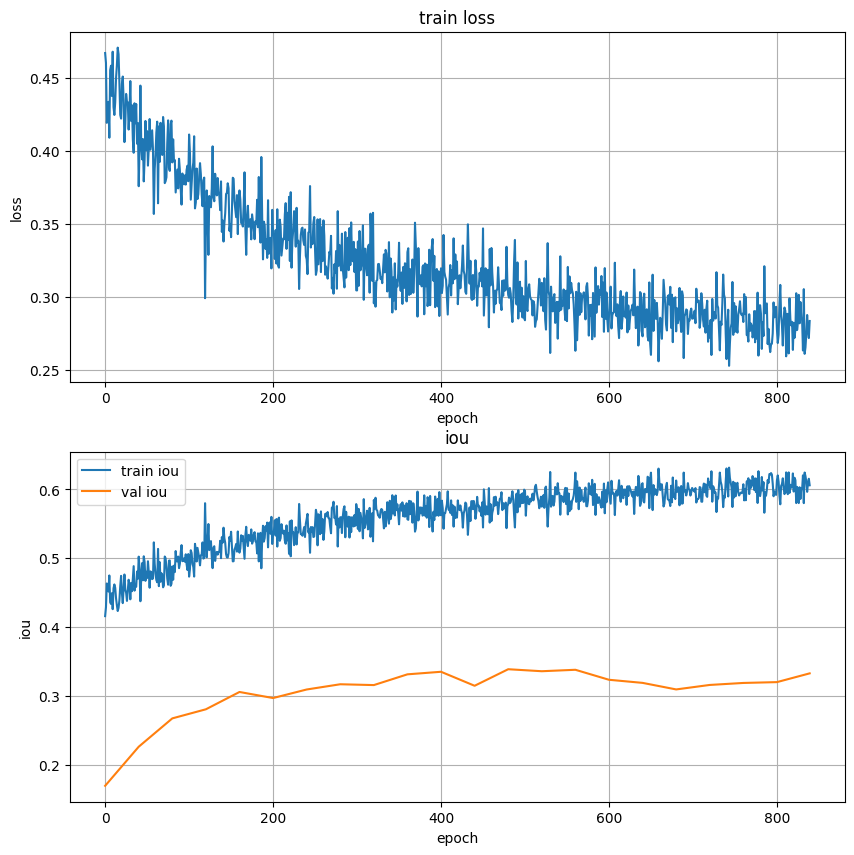

In [14]:
model_name = "def_light_video_pos_56_random"
# create the log directory
log_dir = f"./log/{model_name}"
log_path = f"{log_dir}/{model_name}.log"
model_path = f"./model/{model_name}_best.pth"
# load the log file
# load the log
with open(log_path, "r") as f:
    logs = f.readlines()
loss_dict = {}
iou_train_dict = {}
iou_val_dict = {}
# get the loss and iou using regex
for log in logs:
    # get the epoch
    epoch = re.search(r"Epoch (\d+)", log)
    if epoch is not None:
        epoch = int(epoch.group(1))
        # get the loss
        loss = re.search(r"train loss: ([\d.]+)", log)
        if loss is not None:
            loss_dict[epoch] = float(loss.group(1))
        # get the train iou
        iou = re.search(r"train iou: ([\d.]+)", log)
        if iou is not None:
            iou_train_dict[epoch] = float(iou.group(1))
        # get the val iou
        iou = re.search(r"val iou: ([\d.]+)", log)
        if iou is not None:
            iou_val_dict[epoch] = float(iou.group(1))
# plot the loss and iou
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.grid()
plt.plot(loss_dict.keys(), loss_dict.values())
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("train loss")
plt.subplot(2, 1, 2)
plt.grid()
plt.plot(iou_train_dict.keys(), iou_train_dict.values(), label="train iou")
plt.plot(iou_val_dict.keys(), iou_val_dict.values(), label="val iou")
plt.xlabel("epoch")
plt.ylabel("iou")
plt.title("iou")
plt.legend()
plt.show()

In [15]:
# model = DeformLightVideo(offset_limit=56).cuda()
model = DeformLightVideoPos(offset_limit=56).cuda()
model.load_state_dict(torch.load(model_path))

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
/tmp/ipykernel_423862/1434309113.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please o

<All keys matched successfully>

In [16]:
val_inferer.infer_all_videos(model, use_tqdm=True)

  0%|                                                                                                                 | 0/57 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [12:02<00:00, 12.67s/it]


In [17]:
val_inferer.compute_all_videos_iou()

0.3392295864760093

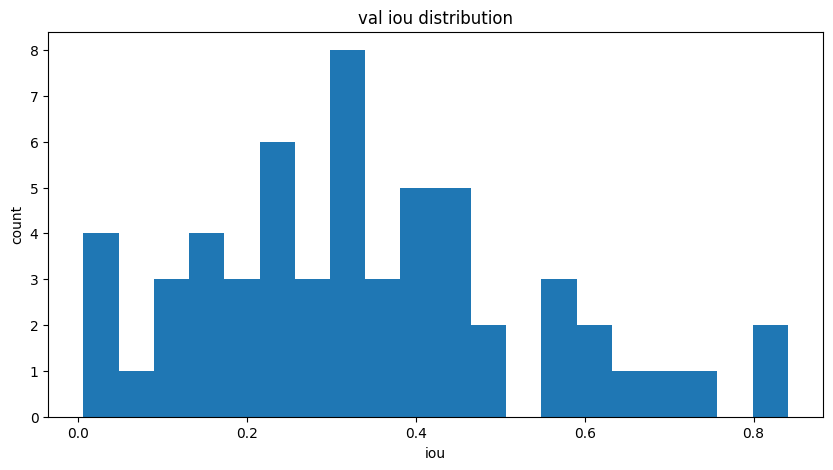

In [18]:
ious = val_inferer.video_ious
# plot the distribution of iou
plt.figure(figsize=(10, 5))
plt.hist(ious, bins=20)
plt.xlabel("iou")
plt.ylabel("count")
plt.title("val iou distribution")
plt.show()

In [ ]:
val_check_idxs = [2, 7, 9, 10, 18, 24, 13, 41, 46, 50, 54, 39]
for idx in val_check_idxs:
    val_inferer.show_video_results(idx)